In [71]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 336 kB in 2s (192 kB/s)
Reading package lists... Done


In [72]:
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [73]:
!pip install -q findspark

In [74]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'

In [75]:
!ls

drive	     spark-3.2.1-bin-hadoop3.2	    spark-3.2.1-bin-hadoop3.2.tgz.1
sample_data  spark-3.2.1-bin-hadoop3.2.tgz  spark-3.2.1-bin-hadoop3.2.tgz.2


In [76]:
import findspark
findspark.init()

In [77]:
# Check the location for Spark
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [78]:
import pyspark
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [79]:
# Import a Spark function from library
# Test if Spark is installed successfully by importing a Spark library.
from pyspark.sql.functions import col

In [80]:
spark = SparkSession.builder \
    .master("local") \
    .appName("StockMarket") \
    .config("spark.executor.memory", "6gb") \
    .getOrCreate()

In [81]:
df =spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('/content/drive/MyDrive/dataset_train_validation.csv')

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
df.show()

+-------+----+------+----+-----+---+----+------+-------+------+------+------+------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+--------------------+------------+-------------+-----------------------+---------------+----------------+----------------------+--------------+---------------+---------------------+--------------+--------------+--------------------+------------+-------------+-----------------------+---------------+--------------

In [84]:
from pyspark.sql.functions import *
df1= df.withColumn("date",concat_ws("-",col("year"),col("month"),col("day")).cast("date"))


In [85]:
df1 = df1.fillna(0)

In [86]:
import pyspark.sql.functions as f
df1 = df1.withColumn('date', f.to_date('date'))

date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df1 = df1.withColumn(name, f.split('date', '-')[index])

df1.show(n=10)

+-------+---+------+----+-----+---+----+------+-------+------+------+------+------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+--------------------+------------+-------------+-----------------------+---------------+----------------+----------------------+--------------+---------------+---------------------+--------------+--------------+--------------------+------------+-------------+-----------------------+---------------+---------------

In [87]:
df_plot = df1.select('date', 'close').toPandas()

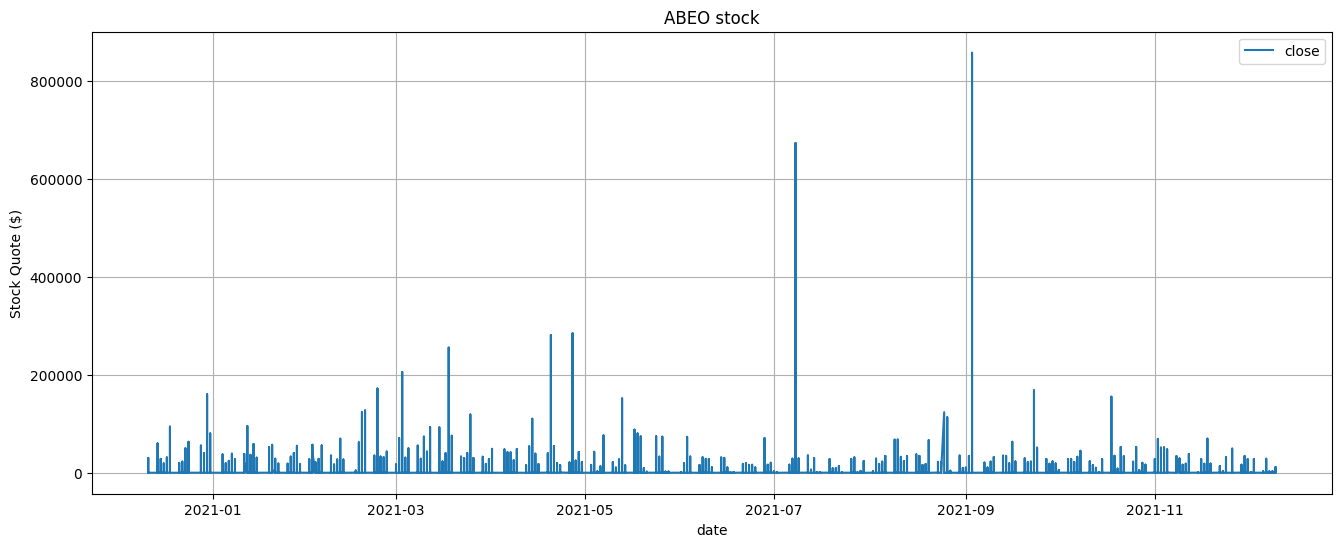

In [88]:
from matplotlib import pyplot as plt
%matplotlib inline
df_plot.set_index('date', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title('ABEO stock')
plt.ylabel('Stock Quote ($)')
plt.show()

In [89]:
df1.toPandas().shape

(100044, 78)

In [90]:
from pyspark.sql.functions import col, isnan, when, count

# Select columns and count null values
null_counts = df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns])

# Show null value counts
null_counts.show()

+-------+---+------+----+-----+---+----+------+------+----+---+-----+----+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+--------------------+------------+-------------+-----------------------+---------------+----------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+-----------------------+---------------+----------------+-----------------

In [91]:
# Drop rows with null values in specific columns
df1 = df1.na.drop(subset=['AVERAGE_SMA_3_CLOSE','EMA_3_CLOSE','MACD_3_CLOSE','AVERAGE_SMA_3_OPENHIGH','EMA_3_OPENHIGH','MACD_3_OPENHIGH','AVERAGE_SMA_3_HIGHLOW','EMA_3_HIGHLOW','MACD_3_HIGHLOW','AVERAGE_SMA_3_VOLUME','EMA_3_VOLUME','MACD_3_VOLUME','AVERAGE_SMA_4_CLOSE','EMA_4_CLOSE','MACD_4_CLOSE','AVERAGE_SMA_4_OPENHIGH','EMA_4_OPENHIGH','MACD_4_OPENHIGH','AVERAGE_SMA_4_HIGHLOW','EMA_4_HIGHLOW','MACD_4_HIGHLOW','AVERAGE_SMA_4_VOLUME','EMA_4_VOLUME','MACD_4_VOLUME','AVERAGE_SMA_7_CLOSE','EMA_7_CLOSE','MACD_7_CLOSE','AVERAGE_SMA_7_OPENHIGH','EMA_7_OPENHIGH','MACD_7_OPENHIGH','AVERAGE_SMA_7_HIGHLOW','EMA_7_HIGHLOW','MACD_7_HIGHLOW','AVERAGE_SMA_7_VOLUME','EMA_7_VOLUME','MACD_7_VOLUME','AVERAGE_SMA_20_CLOSE','EMA_20_CLOSE','MACD_20_CLOSE','AVERAGE_SMA_20_OPENHIGH','EMA_20_OPENHIGH','MACD_20_OPENHIGH','AVERAGE_SMA_20_HIGHLOW','EMA_20_HIGHLOW','MACD_20_HIGHLOW','AVERAGE_SMA_20_VOLUME','EMA_20_VOLUME','MACD_20_VOLUME','AVERAGE_SMA_50_CLOSE','EMA_50_CLOSE','MACD_50_VOLUME','MACD_50_CLOSE','AVERAGE_SMA_50_OPENHIGH','EMA_50_OPENHIGH','MACD_50_OPENHIGH','AVERAGE_SMA_50_HIGHLOW','EMA_50_HIGHLOW','MACD_50_HIGHLOW','AVERAGE_SMA_50_VOLUME','EMA_50_VOLUME', 'DAYS_UNTIL_END_OF_MONTH', 'DAYS_UNTIL_END_OF_TRIMESTER', 'DINAMIC3', 'TARGET']
)

In [92]:
from pyspark.sql.functions import col, isnan, when, count

# Select columns and count null values
null_counts = df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns])

# Show null value counts
null_counts.show()

+-------+---+------+----+-----+---+----+------+------+----+---+-----+----+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+--------------------+------------+-------------+-----------------------+---------------+----------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+------------+-------------+-----------------------+---------------+----------------+-----------------

In [93]:
df1.select('open', 'high', 'low', 'close','date').describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|              open|              high|               low|             close|
+-------+------------------+------------------+------------------+------------------+
|  count|            100044|            100044|            100044|            100044|
|   mean| 841.3942732157839|3062.5168316860436|2860.0477563991954|258.63394031226295|
| stddev|13575.327151839814| 22613.94123577628|22182.926603734144| 4725.936432391785|
|    min|              0.27|            0.2797|            0.2689|            0.2699|
|    max|          829609.0|          847875.0|          861036.0|          858105.0|
+-------+------------------+------------------+------------------+------------------+



In [94]:
df1.show(n=10)

+-------+---+------+----+-----+---+----+------+-------+------+------+------+------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+-------------------+-----------+------------+----------------------+--------------+---------------+---------------------+-------------+--------------+--------------------+--------------+--------------+--------------------+------------+-------------+-----------------------+---------------+----------------+----------------------+--------------+---------------+---------------------+--------------+--------------+--------------------+------------+-------------+-----------------------+---------------+---------------

In [95]:
'''df1.groupBy(['year']).agg({'close':'count'})\
    .withColumnRenamed('count(close)', 'Row Count')\
    .orderBy(["year"],ascending=False)\
    .show()'''

'df1.groupBy([\'year\']).agg({\'close\':\'count\'})    .withColumnRenamed(\'count(close)\', \'Row Count\')    .orderBy(["year"],ascending=False)    .show()'

In [96]:
mapped_rdd = df1.rdd.map(lambda row: (row['year'], 1))
reduced_rdd = mapped_rdd.reduceByKey(lambda a, b: a + b)
year_counts = reduced_rdd.toDF(['year', 'Count']).orderBy('year', ascending=False)
year_counts.show()

+----+-----+
|year|Count|
+----+-----+
|2021|94486|
|2020| 5558|
+----+-----+



In [97]:
trainDF = df1[df1.date <= '2021-8-01']
testDF = df1[df1.date >= '2021-8-01']

In [98]:
trainDF.toPandas().shape

(63123, 78)

In [99]:
testDF.toPandas().shape

(36921, 78)

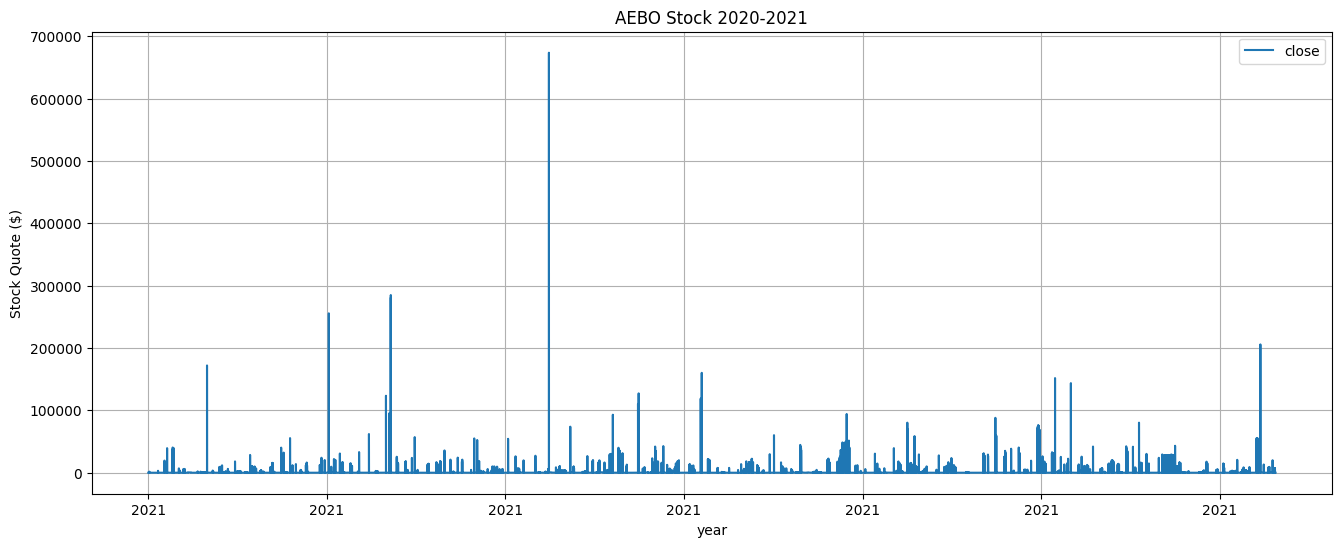

In [100]:
trainDF_plot = trainDF.select('year', 'close').toPandas()
trainDF_plot.set_index('year', inplace=True)
trainDF_plot.plot(figsize=(16, 6), grid=True)
plt.title('AEBO Stock 2020-2021')
plt.ylabel('Stock Quote ($)')
plt.show()

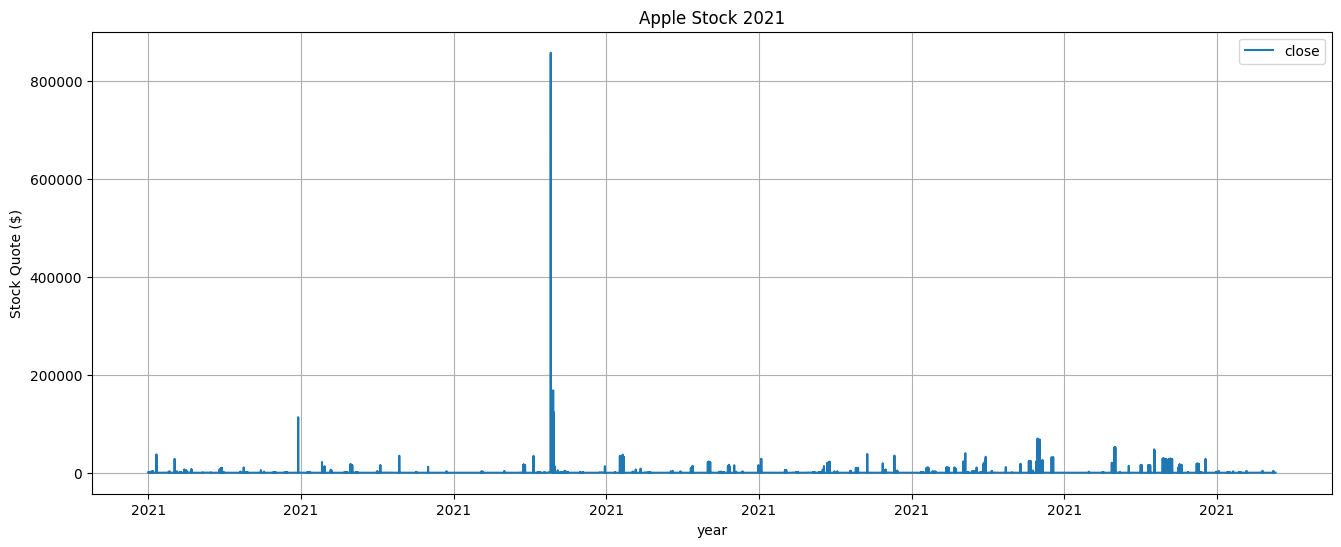

In [101]:
testDF_plot = testDF.select('year', 'close').toPandas()
testDF_plot.set_index('year', inplace=True)
testDF_plot.plot(figsize=(16, 6), grid=True)
plt.title('Apple Stock 2021')
plt.ylabel('Stock Quote ($)')
plt.show()

In [102]:

import numpy as np
trainArray=np.array(trainDF.select('open','high','low','close','volume','AVERAGE_SMA_3_CLOSE').collect())
testArray=np.array(testDF.select('open','high','low','close','volume','AVERAGE_SMA_3_CLOSE').collect())

In [103]:
print(trainArray[0])
print('---------------')
print(testArray[0])

[1.23000e+00 1.23270e+00 1.19000e+00 1.22000e+00 9.41246e+05 1.20000e+00]
---------------
[6.24000e+02 6.34800e-01 6.02300e-01 6.16000e+02 2.78351e+05 6.00000e-01]


In [104]:
from sklearn.preprocessing import MinMaxScaler
minMaxScale = MinMaxScaler()

In [105]:
minMaxScale.fit(trainArray)

MinMaxScaler()

In [106]:
MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler()

In [107]:
testingArray = minMaxScale.transform(testArray)
trainingArray = minMaxScale.transform(trainArray)

In [108]:
print(testingArray[0])
print('---------------')
print(trainingArray[0])

[8.52956586e-04 4.79829383e-07 4.38768078e-07 9.13973662e-04
 3.45592679e-04 7.85237534e-04]
---------------
[1.29915468e-06 1.28774261e-06 1.21220539e-06 1.41030360e-06
 1.16862424e-03 1.57047507e-03]


In [109]:
xtrain = trainingArray[:, 0:-1]
xtest = testingArray[:, 0:-1]
ytrain = trainingArray[:, -1:]
ytest = testingArray[:, -1:]

In [110]:
trainingArray[0]

array([1.29915468e-06, 1.28774261e-06, 1.21220539e-06, 1.41030360e-06,
       1.16862424e-03, 1.57047507e-03])

In [111]:
xtrain[0]

array([1.29915468e-06, 1.28774261e-06, 1.21220539e-06, 1.41030360e-06,
       1.16862424e-03])

In [112]:
ytrain[0]

array([0.00157048])

In [113]:
print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (63123, 5)
xtest shape = (36921, 5)
ytrain shape = (63123, 1)
ytest shape = (36921, 1)


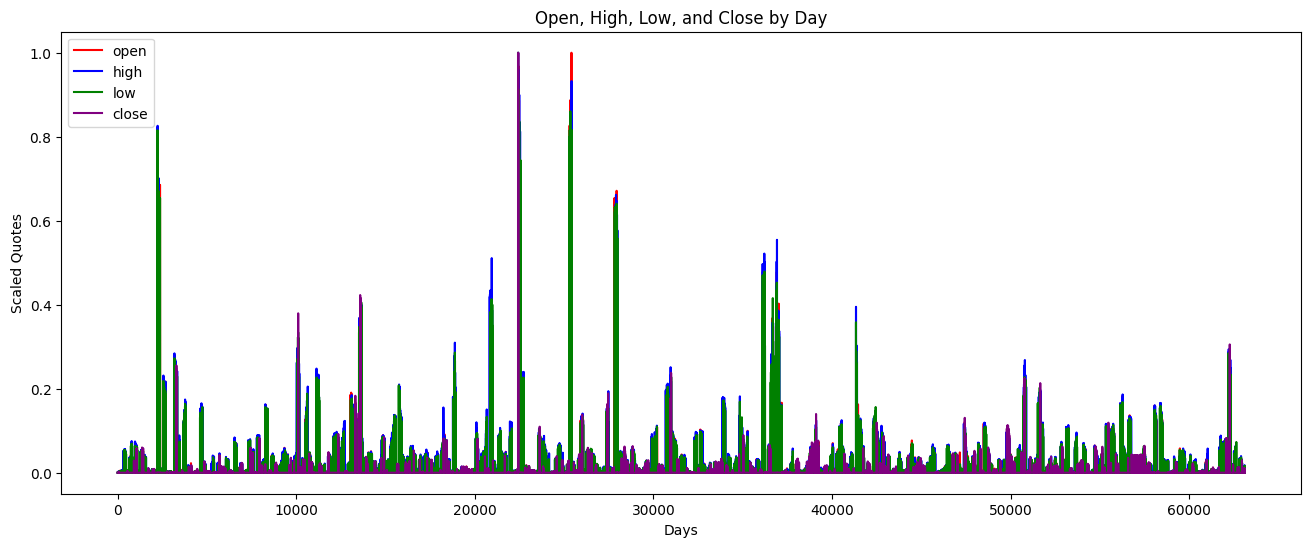

In [114]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='purple', label='close')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low, and Close by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

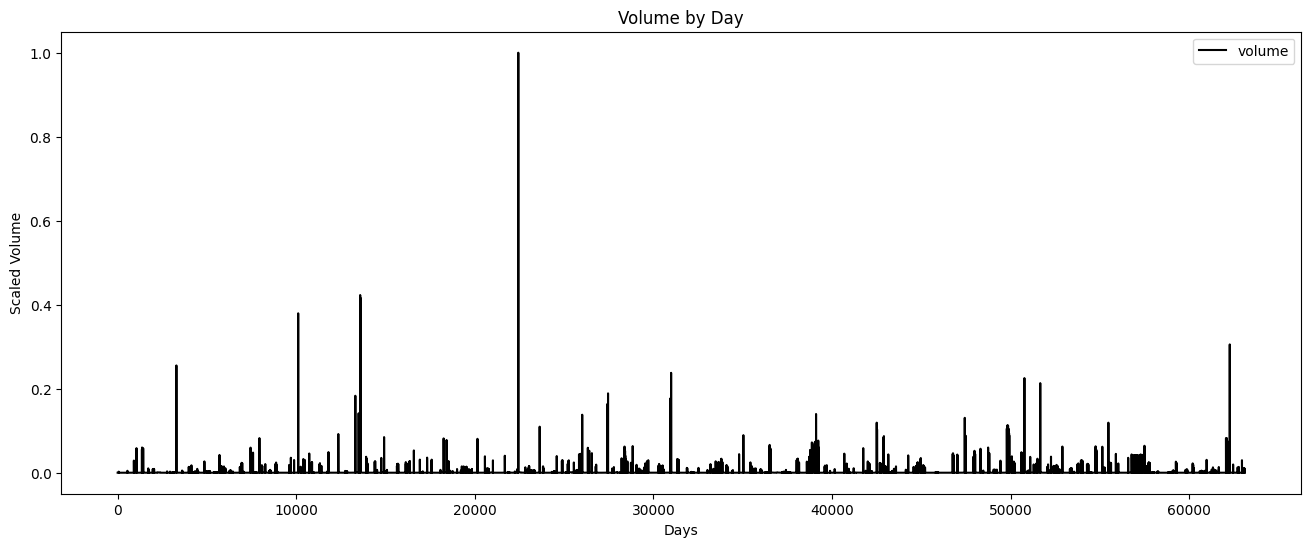

In [115]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,3],color='black', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

In [116]:
from keras import models, layers

In [117]:
#Model application
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='RMSprop')

In [118]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [119]:
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

The shape of xtrain is (63123, 1, 5): 
The shape of xtest is (36921, 1, 5): 


In [120]:
from datetime import datetime as d
start = d.now()

In [121]:
loss = model.fit(xtrain, ytrain, batch_size=10, epochs=10)

Epoch 1/10
6313/6313 [==============================] - 25s 4ms/step - loss: 0.0077
Epoch 2/10
6313/6313 [==============================] - 21s 3ms/step - loss: 0.0073
Epoch 3/10
6313/6313 [==============================] - 23s 4ms/step - loss: 0.0073
Epoch 4/10
6313/6313 [==============================] - 23s 4ms/step - loss: 0.0073
Epoch 5/10
6313/6313 [==============================] - 23s 4ms/step - loss: 0.0073
Epoch 6/10
6313/6313 [==============================] - 20s 3ms/step - loss: 0.0073
Epoch 7/10
6313/6313 [==============================] - 22s 3ms/step - loss: 0.0073
Epoch 8/10
6313/6313 [==============================] - 21s 3ms/step - loss: 0.0073
Epoch 9/10
6313/6313 [==============================] - 34s 5ms/step - loss: 0.0074
Epoch 10/10
6313/6313 [==============================] - 19s 3ms/step - loss: 0.0074


In [122]:
running_secs = (d.now() - start).microseconds
print("In microseconds:",running_secs)

In microseconds: 36097


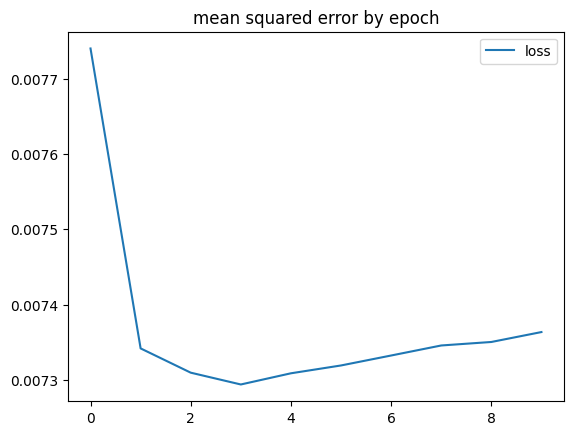

In [123]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [124]:
predicted = model.predict(xtest)

1154/1154 [==============================] - 3s 2ms/step


In [125]:
combined_array = np.concatenate((ytest, predicted), axis = 1)

In [126]:
print(ytest)

[[0.00078524]
 [0.00078524]
 [0.00078524]
 ...
 [0.00444968]
 [0.00444968]
 [0.00444968]]


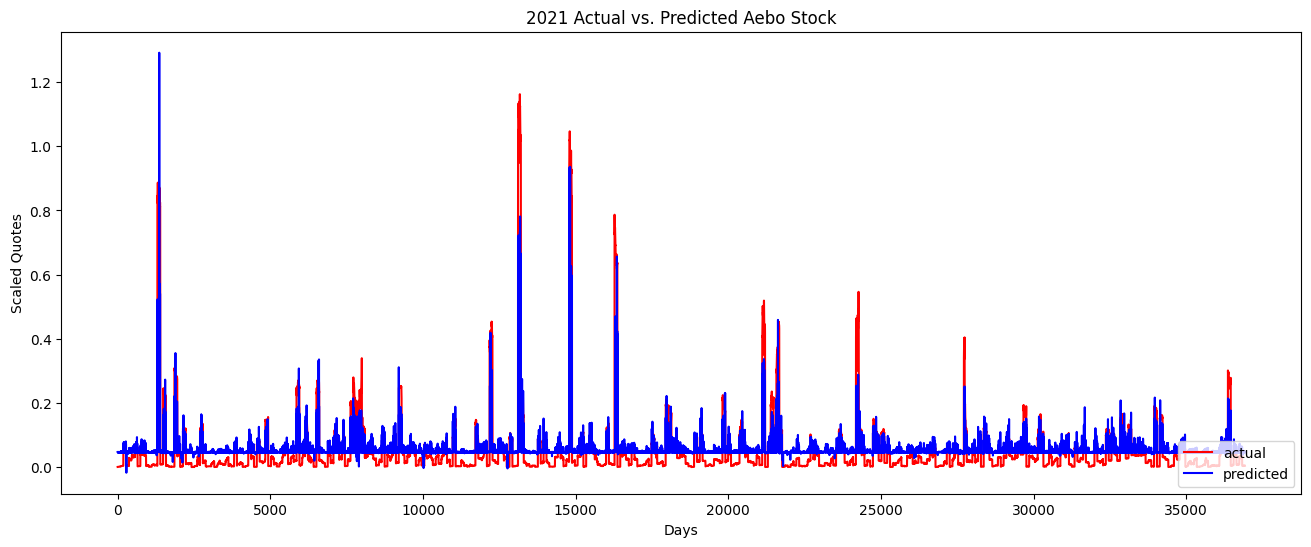

In [127]:
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('2021 Actual vs. Predicted Aebo Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [128]:
import sklearn.metrics as metrics
np.sqrt(metrics.mean_squared_error(ytest,predicted))

0.09803230260340795

In [129]:
predicted.shape

(36921, 1)

In [130]:
print('Shape of xtrain:', xtrain.shape)


Shape of xtrain: (63123, 1, 5)


In [131]:
# Set the number of days to predict
num_days_to_predict = 10

# Duplicate the predicted values to match the expected input shape
duplicated_predicted = np.repeat(predicted, 5, axis=1)

# Reshape the duplicated predicted data to match the input shape
predicted_reshaped = duplicated_predicted.reshape(duplicated_predicted.shape[0], 1, duplicated_predicted.shape[1])

# Generate new predictions for the specified number of days
for _ in range(num_days_to_predict):
    # Generate prediction for the next day based on the previous day's prediction
    next_day_prediction = model.predict(predicted_reshaped[:])

# Extract the newly predicted values
new_prediction = predicted_reshaped[:, -1, 0]

# Print the newly predicted values
print("Newly predicted values for the next", num_days_to_predict, "days:")
for i in range(num_days_to_predict):
    print("Day", i+1, ":", new_prediction[-num_days_to_predict + i])


1154/1154 [==============================] - 2s 2ms/step
Newly predicted values for the next 10 days:
Day 1 : 0.046276692
Day 2 : 0.046297424
Day 3 : 0.048646457
Day 4 : 0.04629852
Day 5 : 0.048440166
Day 6 : 0.046303183
Day 7 : 0.04629557
Day 8 : 0.046303734
Day 9 : 0.046302743
Day 10 : 0.046297852


In [132]:
# Set the number of days for withdrawal
withdrawal_days = 10

# Calculate the predicted close values for the next 'withdrawal_days' days
predicted_close_values = new_prediction.flatten()

# Extract the predicted close value for the next day
next_day_close = predicted_close_values[0]

# Check if there is a loss within the specified withdrawal days
loss_within_withdrawal_days = False
for i in range(1, withdrawal_days+1):
    if predicted_close_values[-i] < next_day_close:
        loss_within_withdrawal_days = True
        break

# Print the predicted close value for the next day
print("Predicted close value for the next day:", next_day_close)

# Provide investment recommendation
previous_day_close = ytest[-1][0]

if next_day_close > previous_day_close:
    print("Recommendation: Invest in profits.")
    if loss_within_withdrawal_days:
        print("Recommendation: Withdraw within", withdrawal_days, "days there is a loss.")
else:
    print("Recommendation: Do not invest.")


Predicted close value for the next day: 0.047066838
Recommendation: Invest in profits.
Recommendation: Withdraw within 10 days there is a loss.


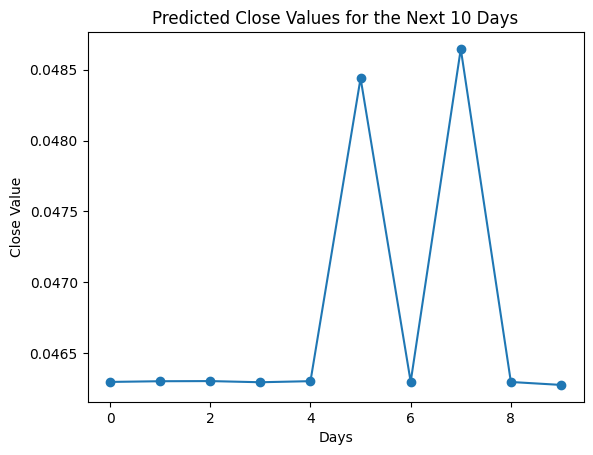

In [133]:
# Plot the predicted close values for the specified withdrawal days
days = range(withdrawal_days)
predicted_values = predicted_close_values[-withdrawal_days:][::-1]  # Reverse the order for plotting
plt.plot(days, predicted_values, marker='o')
plt.title("Predicted Close Values for the Next " + str(withdrawal_days) + " Days")
plt.xlabel("Days")
plt.ylabel("Close Value")
plt.show()

In [134]:
pip install pandas scikit-learn tensorflow


In [140]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanSquaredError

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/dataset_train_validation.csv')

# Preprocessing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.4)
trn_data = scaled_data[:train_size]
tst_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set the sequence length
sequence_length = 10

# Create sequences for training and testing
x, y = create_sequences(trn_data, sequence_length)
x, y = create_sequences(tst_data, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

from datetime import datetime as d
start = d.now()


In [141]:
# Train the model
model.fit(x, y, epochs=10, batch_size=10)

Epoch 1/10
6002/6002 [==============================] - 55s 9ms/step - loss: 1.4402e-05 - mean_squared_error: 1.4402e-05
Epoch 2/10
6002/6002 [==============================] - 53s 9ms/step - loss: 1.4271e-05 - mean_squared_error: 1.4271e-05
Epoch 3/10
6002/6002 [==============================] - 52s 9ms/step - loss: 1.4265e-05 - mean_squared_error: 1.4265e-05
Epoch 4/10
6002/6002 [==============================] - 53s 9ms/step - loss: 1.4237e-05 - mean_squared_error: 1.4237e-05
Epoch 5/10
6002/6002 [==============================] - 50s 8ms/step - loss: 1.4179e-05 - mean_squared_error: 1.4179e-05
Epoch 6/10
6002/6002 [==============================] - 52s 9ms/step - loss: 1.4251e-05 - mean_squared_error: 1.4251e-05
Epoch 7/10
6002/6002 [==============================] - 49s 8ms/step - loss: 1.4170e-05 - mean_squared_error: 1.4170e-05
Epoch 8/10
6002/6002 [==============================] - 51s 9ms/step - loss: 1.4187e-05 - mean_squared_error: 1.4187e-05
Epoch 9/10
6002/6002 [==========

In [142]:
running_secs = (d.now() - start).microseconds
print("In microseconds:",running_secs)

In microseconds: 305589


In [143]:
# Evaluate the model
train_loss, train_mse = model.evaluate(x, y, verbose=0)
test_loss, test_mse = model.evaluate(x, y, verbose=0)
print(f'Train Loss: {train_loss:.4f}  Train MSE: {train_mse:.4f}')
print(f'Test Loss: {test_loss:.4f}  Test MSE: {test_mse:.4f}')




Train Loss: 0.0000  Train MSE: 0.0000
Test Loss: 0.0000  Test MSE: 0.0000


In [144]:
# Predict the stock prices
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Scale back the predictions to the original range
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = scaler.inverse_transform(predicted_test)



1153/1153 [==============================] - 4s 3ms/step


In [147]:
a= ['python','Spark']
b= [305589,36097]

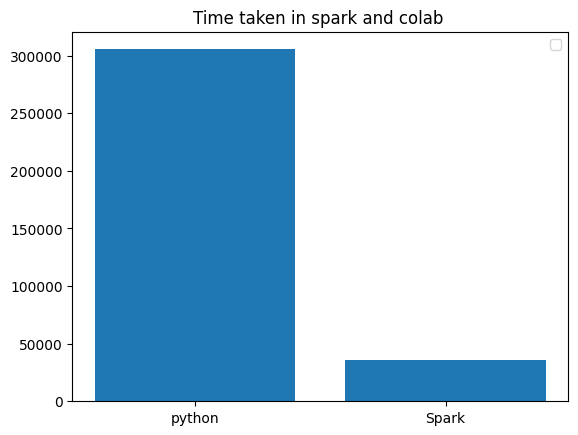

In [148]:
import matplotlib.pyplot as plt
plt.bar(a,b)
plt.legend(loc='upper right')
plt.title('Time taken in spark and colab ')
plt.show()